# MSDS 7331 - Lab 2 - Airline Satisfaction Dataset
***
Team - Triston Hudgins, Shijo Joseph, Osman Kanteh, Douglas Yip

In [1]:
### Douglas to write up some bullshit about dataset

In [86]:
## Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import scatter
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, layout,XAxis, YAxis, Bar, Line
%matplotlib inline

##Decision tree setup
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

***
### Data Preparation 1 ( 10 points total) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [87]:
# load the airline satisfaction  dataset

df = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7331/main/airline.csv') # read in the csv file
df.head()


,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


#### Check for NAs


In [88]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,4)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = pd.concat([nan_df,complete_df], sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 opacity = 0.6,
                 color_discrete_sequence=['red','#808080'],
                 width=800,
                 height=800)
    fig.show()

plot_missingness(df)

print("Missing 310 values if the 'Arrival Delay in Minutes'column; approximately 0.29%.")

Missing 310 values if the 'Arrival Delay in Minutes'column; approximately 0.29%.


#### Remove unwanted columns
ID was removed from the dataset as it was used as a unique identified for each passenger

In [89]:
df["GenderNumeric"] = (df["Gender"]=="Male").astype(int)
df["CustomerTypeNumeric"] = (df["Customer Type"]=="Loyal Customer").astype(int)
df["TypeofTravelNumeric"] = (df["Type of Travel"]=="Personal Travel").astype(int)
df["ClassNumeric"] = df["Class"]
df["ClassNumeric"].replace(['Eco', 'Eco Plus', 'Business'], [0, 1, 2], inplace=True)

df["Arrival Delay in Minutes"]= df["Arrival Delay in Minutes"].fillna(0)


dfclean = df.drop(columns=['id'])

dfclean.isnull().sum() #double check on the missing values - 'arrival delay in minutes =310'

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
GenderNumeric                        0
CustomerTypeNumeric                  0
TypeofTravelNumeric      

In [90]:
#Fill in missing values
dfclean["Arrival Delay in Minutes"].fillna(dfclean["Arrival Delay in Minutes"].median(), inplace=True)

In [91]:
dfclean.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,103904.0,39.379706,15.114964,7.0,27.0,40.0,51.0,85.0
Flight Distance,103904.0,1189.448375,997.147281,31.0,414.0,843.0,1743.0,4983.0
Inflight wifi service,103904.0,2.729683,1.327829,0.0,2.0,3.0,4.0,5.0
Departure/Arrival time convenient,103904.0,3.060296,1.525075,0.0,2.0,3.0,4.0,5.0
Ease of Online booking,103904.0,2.756901,1.398929,0.0,2.0,3.0,4.0,5.0
Gate location,103904.0,2.976883,1.277621,0.0,2.0,3.0,4.0,5.0
Food and drink,103904.0,3.202129,1.329533,0.0,2.0,3.0,4.0,5.0
Online boarding,103904.0,3.250375,1.349509,0.0,2.0,3.0,4.0,5.0
Seat comfort,103904.0,3.439396,1.319088,0.0,2.0,4.0,5.0,5.0
Inflight entertainment,103904.0,3.358158,1.332991,0.0,2.0,4.0,4.0,5.0


In [92]:
dfclean.corr()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,GenderNumeric,CustomerTypeNumeric,TypeofTravelNumeric,ClassNumeric
Age,1.000000,0.099461,0.017859,0.038125,0.024842,-0.001330,0.023000,0.208939,0.160277,0.076444,...,-0.047529,0.035482,-0.049427,0.053611,-0.010152,-0.012105,0.008928,0.281674,-0.048524,0.140565
Flight Distance,0.099461,1.000000,0.007131,-0.020043,0.065717,0.004793,0.056994,0.214869,0.157333,0.128740,...,0.063184,0.073072,0.057540,0.093149,0.002158,-0.002470,0.005828,0.225200,-0.267344,0.451211
Inflight wifi service,0.017859,0.007131,1.000000,0.343845,0.715856,0.336248,0.134718,0.456970,0.122658,0.209321,...,0.120923,0.043193,0.110441,0.132698,-0.017402,-0.019042,0.008974,0.007543,-0.105085,0.036279
Departure/Arrival time convenient,0.038125,-0.020043,0.343845,1.000000,0.436961,0.444757,0.004906,0.070119,0.011344,-0.004861,...,0.072126,0.093333,0.073318,0.014292,0.001005,-0.000918,0.009142,0.206869,0.259763,-0.092788
Ease of Online booking,0.024842,0.065717,0.715856,0.436961,1.000000,0.458655,0.031873,0.404074,0.030014,0.047032,...,0.038762,0.011081,0.035272,0.016179,-0.006371,-0.007947,0.006951,0.019509,-0.133511,0.106391
Gate location,-0.001330,0.004793,0.336248,0.444757,0.458655,1.000000,-0.001159,0.001688,0.003669,0.003517,...,0.002313,-0.035427,0.001681,-0.003830,0.005467,0.005178,0.000333,-0.006078,-0.030700,0.004150
Food and drink,0.023000,0.056994,0.134718,0.004906,0.031873,-0.001159,1.000000,0.234468,0.574556,0.622512,...,0.034746,0.087299,0.033993,0.657760,-0.029926,-0.032466,0.005772,0.059454,-0.063439,0.085908
Online boarding,0.208939,0.214869,0.456970,0.070119,0.404074,0.001688,0.234468,1.000000,0.420211,0.285066,...,0.083280,0.204462,0.074573,0.331517,-0.018982,-0.021874,-0.042260,0.189262,-0.224803,0.322924
Seat comfort,0.160277,0.157333,0.122658,0.011344,0.030014,0.003669,0.574556,0.420211,1.000000,0.610590,...,0.074542,0.191854,0.069218,0.678534,-0.027898,-0.029735,-0.026502,0.159484,-0.124399,0.227444
Inflight entertainment,0.076444,0.128740,0.209321,-0.004861,0.047032,0.003517,0.622512,0.285066,0.610590,1.000000,...,0.378210,0.120867,0.404855,0.691815,-0.027489,-0.030597,0.006117,0.109930,-0.148199,0.194366


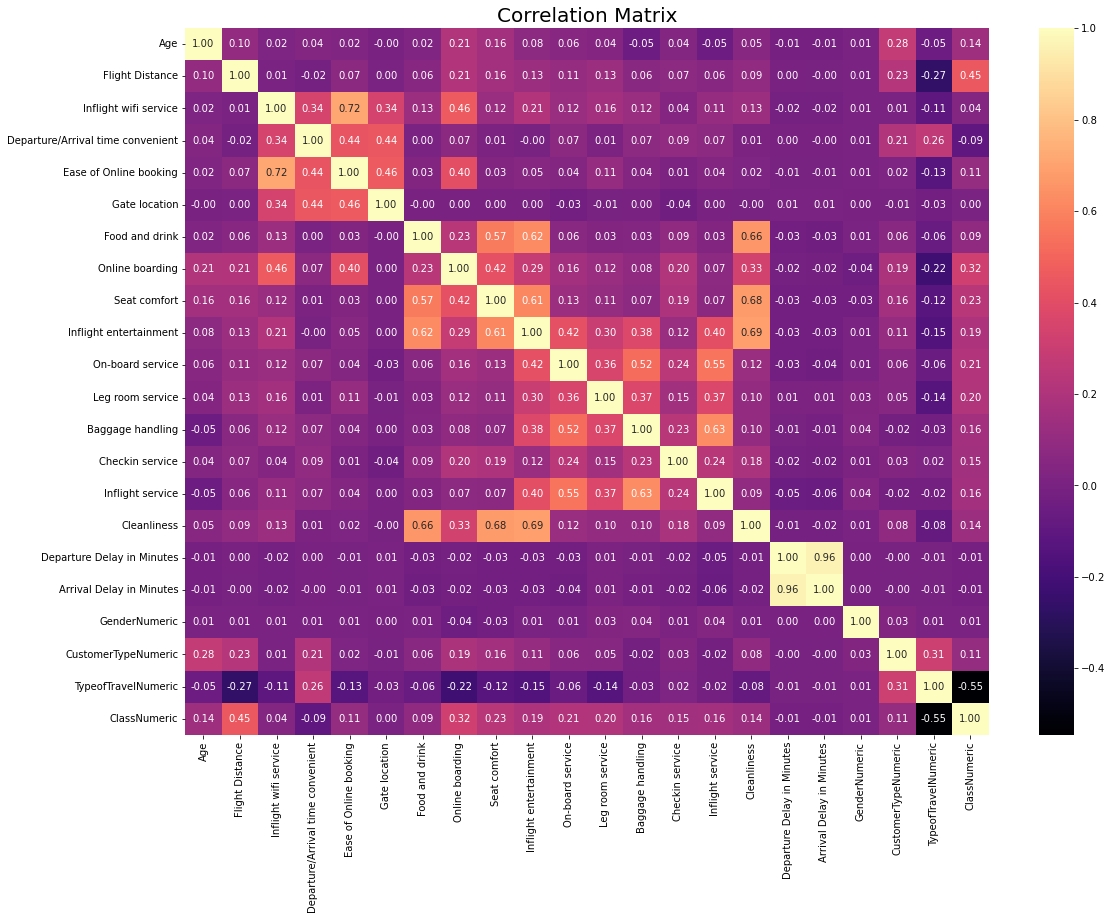

In [56]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(dfclean.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

Very strong correlations (values from 0.8 to 1 or -0.8 to -1.0)
Strong correlations (values from 0.6 to 0.8 or -0.6 to -0.8)
Moderate correlations (values from 0.4 to 0.6 or -0.4 to -0.6) 

In [57]:
#dfclean.corrwith(dfclean["satisfaction"]).sort_values(ascending=False) #sort based on correlation

#### Check distribution of the data

C:\Users\thud1\anaconda3\envs\ML7331\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



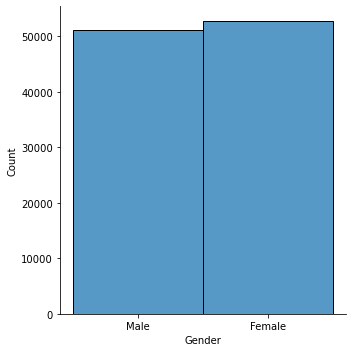

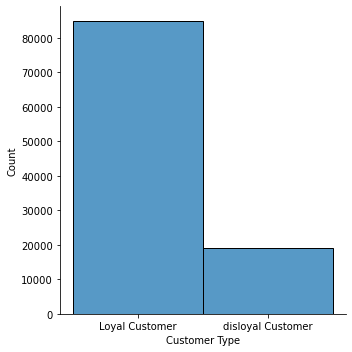

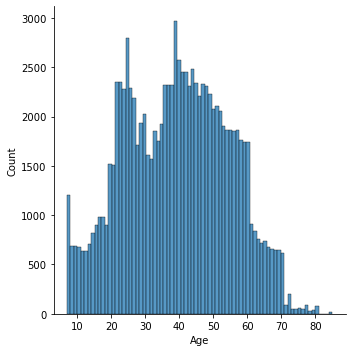

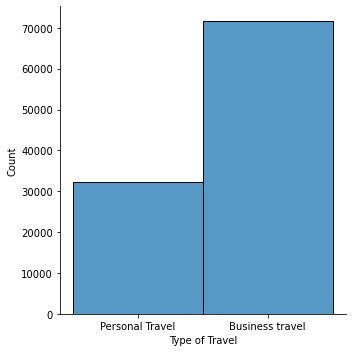

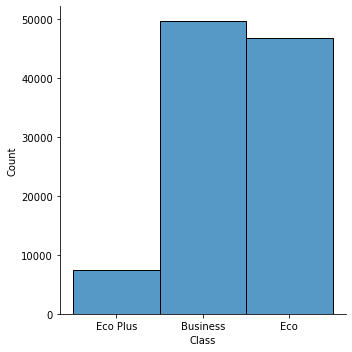

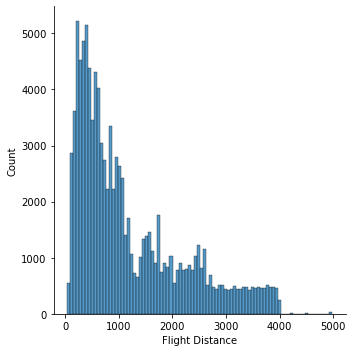

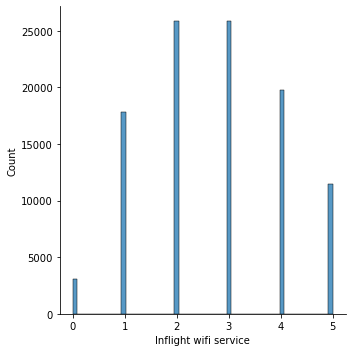

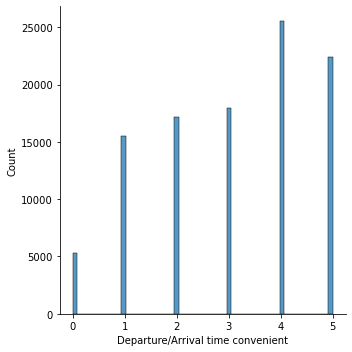

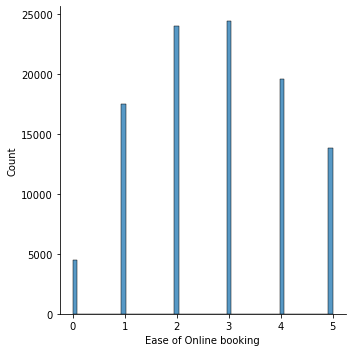

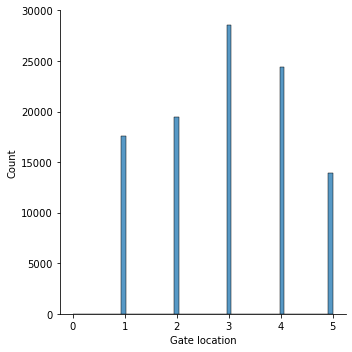

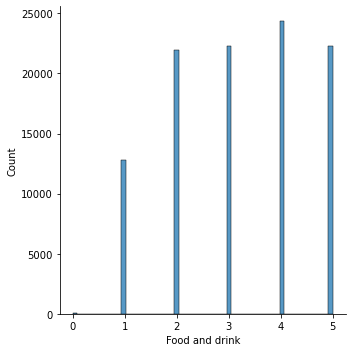

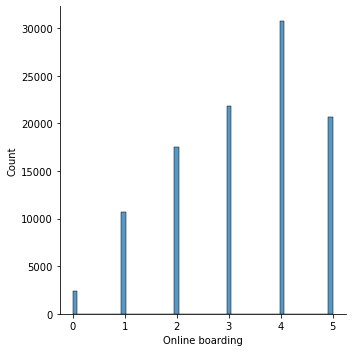

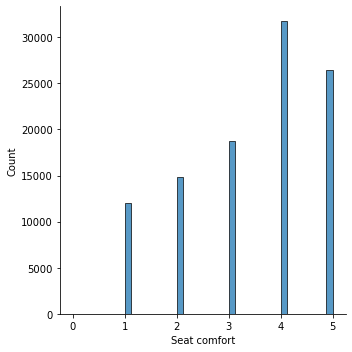

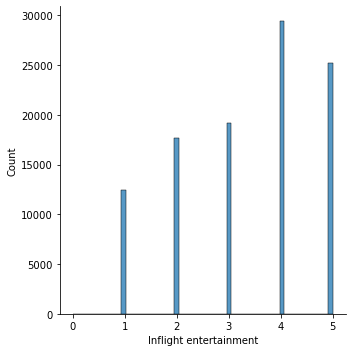

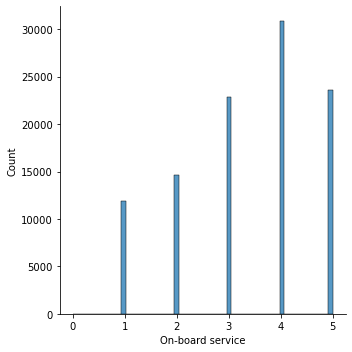

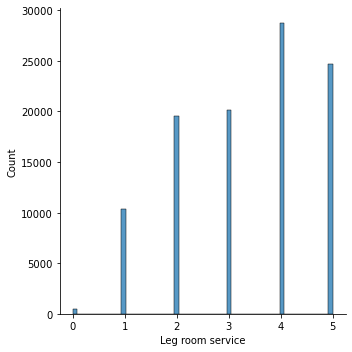

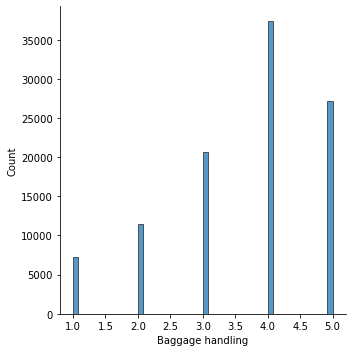

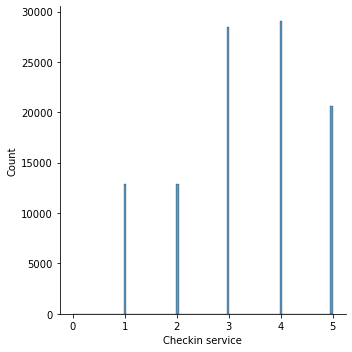

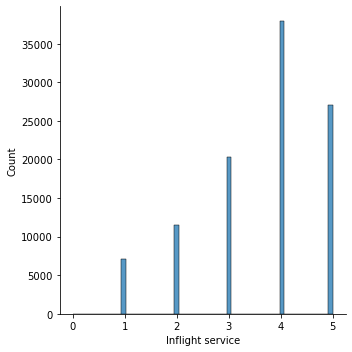

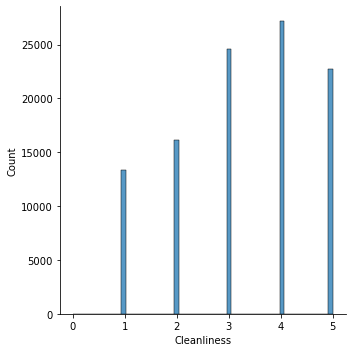

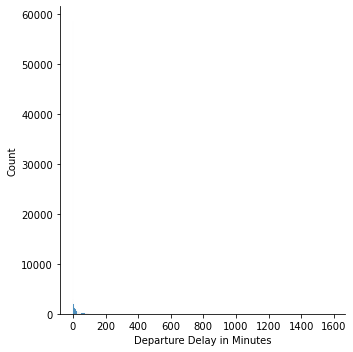

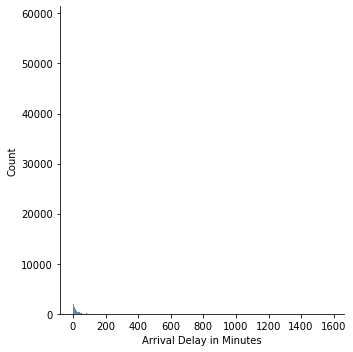

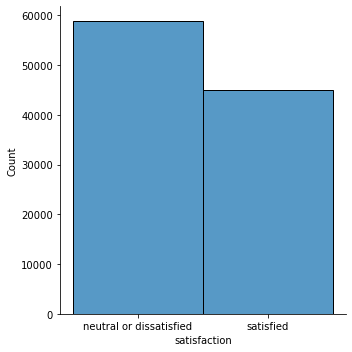

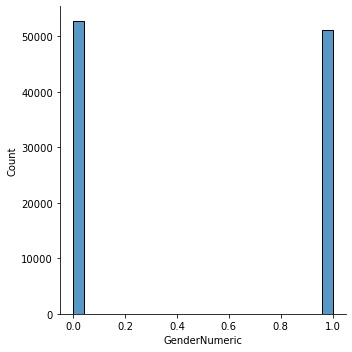

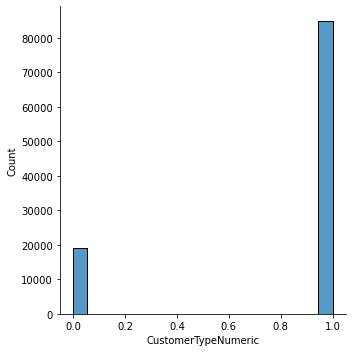

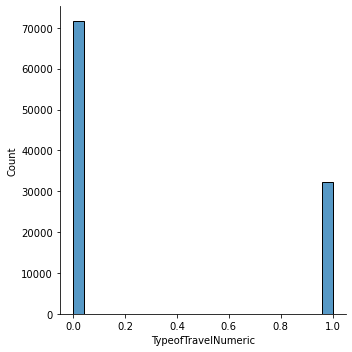

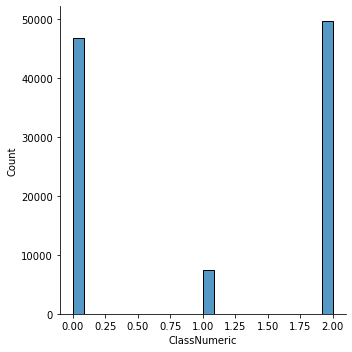

In [58]:
##distribution of the data

for column in dfclean:
    
    sns.displot(x=column, data=dfclean)

***
### Data Preperation 2	(5 points total) Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [93]:
print (dfclean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

#### Summary of values to be used in classification modeling
A total of +100,000 passenger results are recorded in this data set.
We have a combination of categorical, ordinal and continous variable in this dataset.

- __Gender:__- Gender of the passengers (Female, Male) - Categorical Variable
- __Customer Type:__- The customer type (Loyal customer, disloyal customer) - Categorical Variable
- __Age:__- The actual age of the passengers - Continous Variable
- __Type of Travel:__- Purpose of the flight of the passengers (Personal Travel, Business Travel) - Categorical Variable
- __Class:__- Travel class in the plane of the passengers (Business, Eco, Eco Plus) - Categorical Variable
- __Flight distance:__- The flight distance of this journey - Continous Variable
- __Inflight wifi service:__- Satisfaction level of the inflight wifi service (0:Not Applicable;1-5) - Categorical Variable
- __Departure/Arrival time convenient:__- Satisfaction level of Departure/Arrival time convenient - Categorical Variable
- __Ease of Online booking:__- Satisfaction level of online booking - Categorical Variable
- __Gate location:__- Satisfaction level of Gate location - Categorical Variable
- __Food and drink:__- Satisfaction level of Food and drink - Categorical Variable
- __Online boarding:__- Satisfaction level of online boarding - Categorical Variable
- __Seat comfort:__- Satisfaction level of Seat comfort - Categorical Variable
- __Inflight entertainment:__- Satisfaction level of inflight entertainment - Categorical Variable
- __On-board service:__- Satisfaction level of On-board service - Categorical Variable
- __Leg room service:__- Satisfaction level of Leg room service - Categorical Variable
- __Baggage handling:__- Satisfaction level of baggage handling - Categorical Variable
- __Check-in service:__- Satisfaction level of Check-in service - Categorical Variable
- __Inflight service:__- Satisfaction level of inflight service - Categorical Variable
- __Cleanliness:__- Satisfaction level of Cleanliness - Categorical Variable
- __Departure Delay in Minutes:__- Minutes delayed when departure - Continous Variable
- __Arrival Delay in Minutes:__- Minutes delayed when Arrival - Continous Variable
- __Satisfaction:__- Airline satisfaction level(Satisfaction, neutral or dissatisfaction) - Categorical Variable

***
### Modeling and Evaluation 1 (10 points total) Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.


#### What is the F1-measure?
> - F1 measurement consider the combination of  both precision and recall to computed a models performance. Interpretation of the F1 score is a weighted average of the precision and recall values.  When F1 score reaches 1, it is consider to have the best probable model performance while 0 would define it the worst.

#### What does it mean in our model?
> 1) If the model predicts unsatisfied/neutral customers as satisfied customers (high false negatives), the recall probability of our model would be low, and from an airline stand point they could be losing revenue assuming that all things are all right.  We want the model to pin point unsatisfied/neutral customers to ensure the company focuses on the right priorities to maximize revenues and profits. As a result of this, we want a high recall score as we do not want our model to label a unsatisfied/neutral customers as satisfied customers.

> 2) If the model predicts lots of satisfied customers as unsatisfied/neutral customers (high false positives), the precision probability of our model would be low.  This may result in airlines prioritizing investments into intiatives to improve satisfaction when they don't need to resulting in possible lower profies.  As a a reult of this, we want a high precision score to optimize the airlines profits to avoid wasted investments in which we want the model not to label satisfied customers as a unsatisfied/neutral customers.

Given an airline wants to maximize revenues and profits through customer satification, the model requires to have high precision and recall score.  As such, the measure of the F1 score suffices to manage model performance as both these  metrics are contained in this measure. To achieve the most optimal model, our model should have the highest F1 score

***
### Modeling and Evaluation 2 (10 points total) Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

#### Let's check our dataset to see if we have an unbalanced dataset
Before we determine how we train our data, we are going to check our dataset to see if we have an unbalanced dataset

neutral or dissatisfied    58879
satisfied                  45025
Name: satisfaction, dtype: int64


<AxesSubplot:ylabel='Type'>

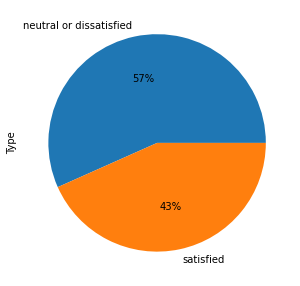

In [94]:
print(df["satisfaction"].value_counts())

fig = plt.figure(figsize=(10, 5))
df.groupby('satisfaction').size().plot(kind='pie',
                                       y = "satisfaction",
                                       label = "Type",
                                       autopct='%1.0f%%')

In [95]:
dfclean["satisfaction"] = dfclean["satisfaction"].apply(lambda x: 1 if x == "satisfied" else 0)

#### Method to train and test model

We will use repeated (10 times) 10-fold cross validation for our analysis.

In [96]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score

In [97]:
from sklearn.model_selection import RepeatedStratifiedKFold
x = df.drop(["satisfaction", "Class", "Gender", "Customer Type", "Type of Travel"],axis=1)
y = df['satisfaction']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
x2 = df.drop(["satisfaction","Class", "Gender", "Customer Type", "Type of Travel"], axis = 1)
y2 = df['satisfaction']

x.head()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,GenderNumeric,CustomerTypeNumeric,TypeofTravelNumeric,ClassNumeric
0,70172,13,460,3,4,3,1,5,3,5,...,4,4,5,5,25,18.0,1,1,1,1
1,5047,25,235,3,2,3,3,1,3,1,...,3,1,4,1,1,6.0,1,0,0,2
2,110028,26,1142,2,2,2,2,5,5,5,...,4,4,4,5,0,0.0,0,1,0,2
3,24026,25,562,2,5,5,5,2,2,2,...,3,1,4,2,11,9.0,0,1,0,2
4,119299,61,214,3,3,3,3,4,5,5,...,4,3,3,3,0,0.0,1,1,0,2


***
### Modeling and Evaluation 3 (20 points total) Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!


#### Logistic Regresion

In [104]:
from sklearn.model_selection import ShuffleSplit

dfLR = dfclean.drop(["Class", "Gender", "Customer Type", "Type of Travel"], axis = 1)

# we want to predict the X and y data as follows:
if 'satisfaction' in dfLR:
    y = dfLR['satisfaction'].values # get the labels we want
    del dfLR['satisfaction'] # get rid of the class label
    X = dfLR.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

dfLR.head()

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,GenderNumeric,CustomerTypeNumeric,TypeofTravelNumeric,ClassNumeric
0,13,460,3,4,3,1,5,3,5,5,...,4,4,5,5,25,18.0,1,1,1,1
1,25,235,3,2,3,3,1,3,1,1,...,3,1,4,1,1,6.0,1,0,0,2
2,26,1142,2,2,2,2,5,5,5,5,...,4,4,4,5,0,0.0,0,1,0,2
3,25,562,2,5,5,5,2,2,2,2,...,3,1,4,2,11,9.0,0,1,0,2
4,61,214,3,3,3,3,4,5,5,3,...,4,3,3,3,0,0.0,1,1,0,2


In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object

iter_num=0

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8759924931427746
confusion matrix
 [[10728  1127]
 [ 1450  7476]]
====Iteration 1  ====
accuracy 0.8748857129108321
confusion matrix
 [[10614  1088]
 [ 1512  7567]]
====Iteration 2  ====
accuracy 0.8751744381887301
confusion matrix
 [[10565  1123]
 [ 1471  7622]]


#### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
DT_model = DecisionTreeClassifier()
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=.2)


In [27]:
n_scores = cross_val_score(DT_model, x, y, scoring='f1_macro', cv=cv)
print('F1 Score of repeated (10 times) 10-fold cross validation: %.3f (%.3f)' % (mean(n_scores), std(n_scores)), "\n\n")

# Testing with data before resampling was done
n_scores_test = cross_val_score(DT_model, x2, y2, cv=cv)
print('F1 Score of splitting data: %.3f (%.3f)' % (mean(n_scores_test), std(n_scores_test)))

F1 Score of repeated (10 times) 10-fold cross validation: 0.946 (0.002) 


F1 Score of splitting data: 0.947 (0.002)


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
KNN_model = KNeighborsClassifier(n_neighbors=1)


In [ ]:
x_scaled = x
scaler = StandardScaler()
scaler.fit(x_scaled)
x_scaled = scaler.transform(x_scaled)

In [ ]:
knn_scores = []
for i in list(range(1,15)):
    knn_loop_model = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn_loop_model, x_scaled, y, scoring='f1_macro', cv=cv)
    knn_scores.append(mean(scores))

In [ ]:
sns.set()
k_scores = pd.DataFrame()
k_scores['k'] = list(range(1, 15))
k_scores['score'] = knn_scores
sns.scatterplot(data=k_scores, x='k', y='score').set(title='K Values and Scores')

In [ ]:
n_scores = cross_val_score(KNN_model, x_scaled, y, scoring='f1_macro', cv=cv)
print('F1 Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

***
### Modeling and Evaluation 4 (10 points total)  Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

#### Logistic Regresion Results

In [ ]:
#Triston will do this

#### Decision Tree Results

In [ ]:
#ousman will do this

#### KNN Results

In [ ]:
#Shijo will do this

### Modeling and Evaluation 5 (10 points total) Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

In [ ]:
#Doug to write bull shit for pros and cons

### Modeling and Evaluation 6 (10 points total) Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

### Deployment (5 points total) 	How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

#Doug to write more bull shit

### Exceptional Work (10 points total) You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

In [ ]:
#Exceptional work would be determining the optimal cutoff (e.g 0.4, 0.5, 0.6 etc)